<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Final Kaggle competition ML

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import csv
import scipy as sp
import copy

import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils
device = torch.device('cuda')


11887


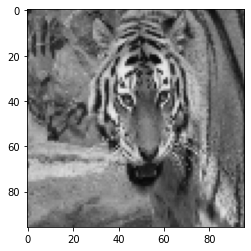

In [3]:
#PATH = './drive/MyDrive/ML-Kaggle/'
#PATH = "/content/drive/MyDrive/ML-Kaggle/"
PATH = '../data/'

x_train_scalar = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_train = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))
x_test =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

print(x_train_scalar.shape[0])

x_train = x_train_scalar

plt.imshow(x_train[0] , cmap='gray', vmin=0, vmax=255)

#x_train = []

#for image in x_train_scalar:
#    imge_out = Image.fromarray(image.astype('uint8'))
#    img_as_img = imge_out.convert("RGB")
#    x_train.append(np.array(img_as_img))
    
#x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))

#plt.imshow(np.transpose(x_train[0], (1, 2 , 0)))

In [4]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))
labels

{'big_cats': 0,
 'butterfly': 1,
 'cat': 2,
 'chicken': 3,
 'cow': 4,
 'dog': 5,
 'elephant': 6,
 'goat': 7,
 'horse': 8,
 'spider': 9,
 'squirrel': 10}

In [5]:
x_train[0].shape

(96, 96)

---

## Hyperparameters

In [65]:
batch_size = 64
num_epochs = 20

#pooling
pooling_filter_size = 2
pooling_stride = 2

#k-fold-validation
k_folds = 5

#dropout
p = 0.1


---

## Preprocessing

In [7]:
# #PCA preprocesing
# from sklearn.decomposition import PCA

# nb_components = len(np.ravel(x_train[0]))
# print(nb_components)

# pca = PCA(n_components=nb_components)
# pca.fit(x_train,y_train)

# plt.grid()
# plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
# plt.xlabel('Number of components')
# plt.ylabel('Explained variance')
# plt.savefig('Scree plot.png')

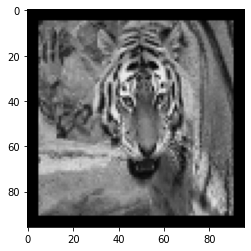

In [9]:
#First preprocessing step 

#Utilitary function for geometric preprocessing
# def flip_verticaly(X):
#     flipped_image = copy.deepcopy(rotate90(X))
#     for idx,channel in enumerate(flipped_image):
#         flipped_image[idx]= np.fliplr(channel)

#     return rotate(flipped_image, 270)


def flip_horizontaly(X):
    flipped_image = copy.deepcopy(X)
    flipped_image= np.fliplr(flipped_image)

    return flipped_image

def rotate90(X):
    rot90_img = copy.deepcopy(X)
    rot90_img= np.rot90(rot90_img)
    return rot90_img

def rotate(X,degree):
    rot_img = copy.deepcopy(X)
    rot_img= sp.ndimage.rotate(rot_img, degree, reshape=False)
    return rot_img

#An adaptation from:
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = sp.ndimage.zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = sp.ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def blur(X,blur_factor):
    blur_img = copy.deepcopy(X)
    blur_img= sp.ndimage.gaussian_filter(blur_img, sigma=blur_factor)
    return blur_img

plt.imshow(clipped_zoom(x_train[0],0.9), cmap='gray', vmin=0, vmax=255)

In [10]:
zoom_factors = [0.9, 1.1, 1.4, 1.6]
x_train_zoomed_vertical = np.array([clipped_zoom(x,np.random.choice(zoom_factors)) for x in x_train])
x_train_zoomed_horizontal = np.array([rotate(clipped_zoom(rotate90(x),np.random.choice(zoom_factors)),270) for x in x_train])

In [11]:
x_train_rotated = np.array([rotate(x,round(np.random.random()*360)) for x in x_train])

In [12]:
x_train_flipped_horizontally = np.array([flip_horizontaly(x) for x in x_train])

In [13]:
augmented_x_train = np.concatenate([x_train, x_train_zoomed_horizontal, x_train_zoomed_vertical, x_train_rotated, x_train_flipped_horizontally], axis=0)
augmented_x_train.shape

(59435, 96, 96)

In [14]:
augmented_y_train = np.concatenate([y_train]*5)
augmented_y_train.shape

(59435,)

In [15]:
# SAVE AUGMENTED TRAINING SET
pkl.dump(augmented_x_train,open(PATH+'x_train_aug.pkl', 'wb'))
pkl.dump(augmented_y_train,open(PATH+'y_train_aug.pkl', 'wb'))

In [16]:
# LOAD AUGMENTED TRAINING SET
x_train = pkl.load(open(PATH+'x_train_aug.pkl', 'rb'))
y_train = pkl.load(open(PATH+'y_train_aug.pkl', 'rb'))

---
## Model

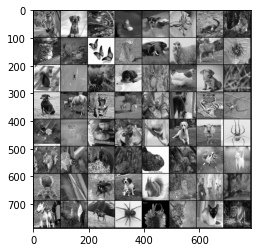

In [8]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda')
#device = torch.device("cpu")

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    

#y_train = np.array([labels[y] for y in y_train])
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0, random_state=4)

# idx = np.random.choice(np.arange(len(x_train)), 10000, replace=False)
# x_sample = x_train[idx]
# y_sample = y_train[idx]

x_train_tensor = torch.tensor(x_train, dtype=float)[:, None, :, :]
y_train_tensor = torch.tensor(np.array([labels[y] for y in y_train]), dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))]
)
train_dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False)

#x_train_tensor.shape
real_batch = next(iter(train_dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [93]:
conv1 = nn.Conv2d(1,25,7)
conv2 = nn.Conv2d(25,25,7, padding = "same")
batchNorm2d1 = nn.BatchNorm2d(25,momentum=0.3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv3 = nn.Conv2d(25, 50,5)
batchNorm2d2 = nn.BatchNorm2d(50,momentum=0.3)
conv4 = nn.Conv2d(50 ,100,3)
batchNorm2d3 = nn.BatchNorm2d(100,momentum=0.3)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")

images
torch.Size([64, 1, 96, 96])

CONV1
torch.Size([64, 25, 90, 90])
POOL1
torch.Size([64, 25, 45, 45])

CONV2
torch.Size([64, 25, 45, 45])
POOL2
torch.Size([64, 25, 22, 22])

CONV3
torch.Size([64, 50, 18, 18])
POOL3
torch.Size([64, 50, 9, 9])



In [103]:
#AlexNet type shit
class AlexNet(nn.Module): 
    def __init__(self,pooling_filter_size,pooling_stride, p): 
        super().__init__()
        print("AlexNet")
        self.conv1 = nn.Conv2d(1,25,7)
        self.convSame7 = nn.Conv2d(25,25,7, padding = "same")
        self.batchNorm2d1 = nn.BatchNorm2d(25,momentum=0.3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(25, 50,5)
        self.convSame5 = nn.Conv2d(50,50,5, padding = "same")
        self.batchNorm2d2 = nn.BatchNorm2d(50,momentum=0.3)
        self.conv3 = nn.Conv2d(50 ,100,3)
        self.convSame3 = nn.Conv2d(100,100,3, padding = "same")
        self.batchNorm2d3 = nn.BatchNorm2d(100,momentum=0.3)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(100*9*9, 480) 
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 120)
        self.fc4 = nn.Linear(120, 11)
        self.dropout = nn.Dropout(p) 
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batchNorm2d1(x)
        
        x = F.relu(self.convSame7(x))
        x = self.batchNorm2d1(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchNorm2d2(x)
        
        x = F.relu(self.convSame5(x))
        x = self.batchNorm2d2(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchNorm2d3(x)
        
        x = F.relu(self.convSame3(x))
        x = self.batchNorm2d3(x)
        
        x = x.view(-1, 100*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x


In [104]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [105]:
# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

running_loss = 0 
printfreq = 25

network = AlexNet(pooling_filter_size, pooling_stride, p).to(device)
network.apply(reset_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    network = AlexNet(pooling_filter_size, pooling_stride, p).to(device)
    network.apply(reset_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
    

    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            optimizer.zero_grad()
            outputs = network(inputs)  # forward pass 
            outputs = outputs.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % printfreq == printfreq - 1 :
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / printfreq))
                current_loss = 0.0
         # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)
    
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float().to(device)
        targets = targets.to(device)

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

AlexNet
Reset trainable parameters of layer = Conv2d(1, 25, kernel_size=(7, 7), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(25, 25, kernel_size=(7, 7), stride=(1, 1), padding=same)
Reset trainable parameters of layer = BatchNorm2d(25, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
Reset trainable parameters of layer = BatchNorm2d(50, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = BatchNorm2d(100, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=8100, ou

Loss after mini-batch    50: 2.208
Loss after mini-batch    75: 2.173
Loss after mini-batch   100: 2.174
Loss after mini-batch   125: 2.083
Starting epoch 3
Loss after mini-batch    25: 2.018
Loss after mini-batch    50: 1.975
Loss after mini-batch    75: 1.945
Loss after mini-batch   100: 1.925
Loss after mini-batch   125: 1.871
Starting epoch 4
Loss after mini-batch    25: 1.830
Loss after mini-batch    50: 1.755
Loss after mini-batch    75: 1.747
Loss after mini-batch   100: 1.699
Loss after mini-batch   125: 1.728
Starting epoch 5
Loss after mini-batch    25: 1.618
Loss after mini-batch    50: 1.595
Loss after mini-batch    75: 1.593
Loss after mini-batch   100: 1.591
Loss after mini-batch   125: 1.532
Starting epoch 6
Loss after mini-batch    25: 1.478
Loss after mini-batch    50: 1.466
Loss after mini-batch    75: 1.441
Loss after mini-batch   100: 1.467
Loss after mini-batch   125: 1.375
Starting epoch 7
Loss after mini-batch    25: 1.346
Loss after mini-batch    50: 1.321
Loss 

Loss after mini-batch    50: 0.176
Loss after mini-batch    75: 0.177
Loss after mini-batch   100: 0.191
Loss after mini-batch   125: 0.191
Starting epoch 18
Loss after mini-batch    25: 0.134
Loss after mini-batch    50: 0.123
Loss after mini-batch    75: 0.103
Loss after mini-batch   100: 0.110
Loss after mini-batch   125: 0.101
Starting epoch 19
Loss after mini-batch    25: 0.058
Loss after mini-batch    50: 0.060
Loss after mini-batch    75: 0.048
Loss after mini-batch   100: 0.054
Loss after mini-batch   125: 0.053
Starting epoch 20
Loss after mini-batch    25: 0.030
Loss after mini-batch    50: 0.028
Loss after mini-batch    75: 0.031
Loss after mini-batch   100: 0.027
Loss after mini-batch   125: 0.027
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 60 %
--------------------------------
FOLD 3
--------------------------------
AlexNet
Reset trainable parameters of layer = Conv2d(1, 25, kernel_size=(7, 7), stride=(1, 1))
Reset trainable p

Loss after mini-batch   100: 1.807
Loss after mini-batch   125: 1.781
Starting epoch 5
Loss after mini-batch    25: 1.678
Loss after mini-batch    50: 1.701
Loss after mini-batch    75: 1.678
Loss after mini-batch   100: 1.637
Loss after mini-batch   125: 1.605
Starting epoch 6
Loss after mini-batch    25: 1.513
Loss after mini-batch    50: 1.508
Loss after mini-batch    75: 1.568
Loss after mini-batch   100: 1.541
Loss after mini-batch   125: 1.494
Starting epoch 7
Loss after mini-batch    25: 1.431
Loss after mini-batch    50: 1.384
Loss after mini-batch    75: 1.381
Loss after mini-batch   100: 1.387
Loss after mini-batch   125: 1.324
Starting epoch 8
Loss after mini-batch    25: 1.241
Loss after mini-batch    50: 1.231
Loss after mini-batch    75: 1.242
Loss after mini-batch   100: 1.242
Loss after mini-batch   125: 1.305
Starting epoch 9
Loss after mini-batch    25: 1.169
Loss after mini-batch    50: 1.198
Loss after mini-batch    75: 1.103
Loss after mini-batch   100: 1.116
Loss 

In [ ]:
# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(31)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

running_loss = 0 
printfreq = 25

network = AlexNet(pooling_filter_size, pooling_stride).to(device)
network.apply(reset_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad()
        outputs = network(inputs)  # forward pass 
        outputs = outputs.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % printfreq == printfreq - 1 :
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / printfreq))
            current_loss = 0.0
     # Process is complete.
    
# Saving the model
save_path = f'./bagging/model-fold-31.pth'
torch.save(network.state_dict(), save_path)

In [91]:
network1 = AlexNet(pooling_filter_size, pooling_stride,p).to(device)
network1.load_state_dict(torch.load('./model-fold-0.pth'))
network1.eval()

network2 = AlexNet(pooling_filter_size, pooling_stride,p).to(device)
network2.load_state_dict(torch.load('./model-fold-1.pth'))
network2.eval()

network3 = AlexNet(pooling_filter_size, pooling_stride,p).to(device)
network3.load_state_dict(torch.load('./model-fold-2.pth'))
network3.eval()

network4 = AlexNet(pooling_filter_size, pooling_stride,p).to(device)
network4.load_state_dict(torch.load('./model-fold-3.pth'))
network4.eval()

network5 = AlexNet(pooling_filter_size, pooling_stride,p).to(device)
network5.load_state_dict(torch.load('./model-fold-4.pth'))
network5.eval()

x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))
x_test = x_test_scalar
x_test = torch.tensor(x_test, dtype=float)[:, None, :, :]

header = ["Id", "class"]
id_value = 0

classifications =[]
for image in tqdm.tqdm(x_test):
    image = torch.reshape(image, (1,1,96, 96)).to(device)
    classifications.append([id_value, (network1(image.float()) + network2(image.float()) + network3(image.float()) + network4(image.float()) + network5(image.float())).argmax(dim=1)[0].item()])
    id_value += 1

y = "./submission.csv"
with open(y, 'w', newline='') as work:
    z = csv.writer(work)
    z.writerow(header)
    z.writerows(classifications)

AlexNet
AlexNet
AlexNet
AlexNet
AlexNet


100%|███████████████████████████████████████████████████████████████████████████| 17831/17831 [01:16<00:00, 232.86it/s]


In [34]:
network = Net()
network.load_state_dict(torch.load('./model-fold-0.pth'))
network.eval()

Net(
  (conv1): Conv2d(1, 25, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8100, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=11, bias=True)
)

In [30]:
x_test_tensor = torch.tensor(x_test, dtype=float)
y_test_tensor = torch.tensor(y_test, dtype=float)

test_dataset = CustomTensorDataset(tensors=(x_test_tensor, y_test_tensor), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

NameError: ignored

In [ ]:
numberOfBatches = 0
totalAccuracy = 0

for i, data in enumerate(test_dataloader):
    numberOfBatches += 1
    inputs, labels = data
    
    outputs = network(inputs.float())
    
    print(outputs.shape)

    preds = outputs.argmax(dim=1).cpu()
    
    print(preds.shape)
    print(preds)
    print(labels.shape)
    print(labels)
    print("")

    totalAccuracy += accuracy_score(labels.cpu(), preds.cpu())

print(totalAccuracy / numberOfBatches)

In [108]:
def make_submission(x_test, network):
    header = ["Id", "class"]
    id_value = 0
    
    classifications =[]
    for image in tqdm.tqdm(x_test):
        image = torch.reshape(image[0], (1,1,96, 96))
        classifications.append([id_value, network(image.float()).argmax(dim=1)[0].item()])
        id_value += 1
    
    y = PATH+"./submission.csv"
    with open(y, 'w', newline='') as work:
        z = csv.writer(work)
        z.writerow(header)
        z.writerows(classifications)

In [12]:
x_test

tensor([[[[123., 118., 111.,  ...,  64.,  64.,  63.],
          [123., 118., 111.,  ...,  68.,  66.,  66.],
          [128., 123., 114.,  ...,  66.,  64.,  70.],
          ...,
          [128., 121., 115.,  ..., 144., 134., 117.],
          [126., 120., 115.,  ..., 133., 126., 124.],
          [127., 122., 117.,  ..., 124., 126., 135.]]],


        [[[ 39.,  51.,  59.,  ...,  27.,  24.,  32.],
          [ 41.,  57.,  95.,  ...,  26.,  25.,  33.],
          [ 50.,  47., 223.,  ...,  25.,  27.,  35.],
          ...,
          [ 70.,  67.,  67.,  ...,  59.,  58.,  59.],
          [ 46.,  57.,  69.,  ...,  57.,  62.,  58.],
          [ 34.,  68.,  81.,  ...,  54.,  57.,  57.]]],


        [[[126., 119., 119.,  ..., 159., 157., 159.],
          [117., 121., 117.,  ..., 154., 153., 152.],
          [120., 113., 120.,  ..., 154., 153., 154.],
          ...,
          [ 62., 116., 132.,  ..., 133., 172., 152.],
          [115.,  96., 107.,  ..., 133., 146., 130.],
          [157., 119., 100., 

In [109]:
x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))
x_test = x_test_scalar

x_test = torch.tensor(x_test, dtype=float)[:, None, :, :].to(device)
y_test = torch.tensor(np.array([1 for y in x_test]), dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))]
)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=False)







network = AlexNet(pooling_filter_size, pooling_stride, p).to(device)
network.load_state_dict(torch.load('./model-fold-0.pth'))
network.eval()

make_submission(test_dataloader, network)

AlexNet


100%|███████████████████████████████████████████████████████████████████████████| 17831/17831 [00:33<00:00, 527.64it/s]


### MODEL GRAVEYARD

In [ ]:
conv1 = nn.Conv2d(1,3,5)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,5)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)
print("")

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)
print("")

x = pool(x)
print("POOL2")
print(x.shape)
print("")

In [1]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5) 
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(6*21*21, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*21*21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

NameError: name 'nn' is not defined

In [ ]:
conv1 = nn.Conv2d(1,3,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,5)
conv3 = nn.Conv2d(6,16,7)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")

In [ ]:
conv1 = nn.Conv2d(1,100,7)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(100,200,5)
conv3 = nn.Conv2d(200,400,3)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")

In [ ]:
#AlexNet type shit
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,25,7)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(25, 50,5)
        self.conv3 = nn.Conv2d(50 ,100,3)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(100*9*9, 480) 
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 120)
        self.fc4 = nn.Linear(120, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 100*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5)
        self.conv3 = nn.Conv2d(6,16,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*7*7, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5)
        self.conv3 = nn.Conv2d(6,16,7)
        # 5*5 comes from the dimension of the last cvnet layer
        self.fc1 = nn.Linear(16*7*7, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [ ]:
conv1 = nn.Conv2d(1,3,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,3)
conv3 = nn.Conv2d(6,16,5)
conv4 = nn.Conv2d(16,26,7)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")

x = conv4(x)
print("CONV3")
print(x.shape)

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,3)
        self.conv3 = nn.Conv2d(6,16,5)
        self.conv4 = nn.Conv2d(16,26,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(26*3*3, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 26*3*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)